# Otimização de Portfólio de Ações com Algoritmos Genéticos

O problema que vamos resolver é a **otimização de portfólio de ações**, onde o objetivo é distribuir um **capital limitado** entre várias **ações** de modo a **maximizar o retorno esperado** e **minimizar o risco**.

O algoritmo genético será utilizado para:
1. **Seleção** das melhores ações para o portfólio.
2. **Cruzamento** de diferentes alocações de ações para explorar novas combinações.
3. **Mutação** para introduzir variação e evitar a convergência prematura.
4. **Avaliação** com base no **índice de Sharpe**, que é uma métrica que balanceia **risco** e **retorno**.

A **função de fitness** será baseada no **índice de Sharpe**, que é calculado da seguinte forma:

A fórmula do índice de Sharpe é:

**Sharpe Ratio = (Retorno do Portfólio - Taxa Livre de Risco) / Desvio Padrão do Portfólio**

Onde:
- **Retorno do Portfólio** é a soma ponderada dos retornos diários das ações no portfólio.
- **Desvio Padrão do Portfólio** é o desvio padrão ponderado dos retornos diários das ações no portfólio.
- **Taxa Livre de Risco** é uma taxa de retorno considerada segura, como o rendimento de títulos do governo. Vamos assumir que a taxa livre de risco é **0** para simplificação.

Nosso objetivo será maximizar esse valor, buscando um **portfólio de ações** com o melhor equilíbrio entre **risco** e **retorno**.

Vamos agora passar para a criação dos dados iniciais e a definição da função de fitness.


In [40]:
import yfinance as yf
import pandas as pd

# Definindo as ações que serão usadas
tickers = ['AAPL', 'MSFT', 'TSLA', 'AMZN', 'GOOGL']

# Baixar dados históricos (últimos 5 anos)
data = yf.download(tickers, start='2018-01-01', end='2023-01-01', auto_adjust=True)

# Exibir as primeiras linhas dos dados coletados para ver as colunas
data.head()


[*********************100%***********************]  5 of 5 completed


Price           Close                                                   High  \
Ticker           AAPL       AMZN      GOOGL       MSFT       TSLA       AAPL   
Date                                                                           
2018-01-02  40.426826  59.450500  53.340599  79.328514  21.368668  40.436216   
2018-01-03  40.419773  60.209999  54.250641  79.697716  21.150000  40.964244   
2018-01-04  40.607533  60.479500  54.461376  80.399178  20.974667  40.710794   
2018-01-05  41.069851  61.457001  55.183544  81.395973  21.105333  41.156683   
2018-01-08  40.917324  62.343498  55.378376  81.479034  22.427334  41.213026   

Price                                                   ...       Open  \
Ticker           AMZN      GOOGL       MSFT       TSLA  ...       AAPL   
Date                                                    ...              
2018-01-02  59.500000  53.478274  79.660781  21.474001  ...  39.933990   
2018-01-03  60.274502  54.478276  79.845393  21.683332  ...  40.490179   
2018-01-04  60.793499  54.874897  80.906809  21.236668  ...  40.492536   
2018-01-05  61.457001  55.347065  81.599026  21.149332  ...  40.703743   
2018-01-08  62.653999  55.624402  81.755926  22.468000  ...  40.917324   

Price                                                      Volume            \
Ticker           AMZN      GOOGL       MSFT       TSLA       AAPL      AMZN   
Date                                                                          
2018-01-02  58.599998  52.337119  79.494647  20.799999  102223600  53890000   
2018-01-03  59.415001  53.376383  79.430056  21.400000  118071600  62176000   
2018-01-04  60.250000  54.527481  79.919234  20.858000   89738400  60442000   
2018-01-05  60.875500  54.843584  80.906805  21.108000   94640000  70894000   
2018-01-08  61.799999  55.218833  81.405196  21.066668   82271200  85590000   

Price                                      
Ticker         GOOGL      MSFT       TSLA  
Date                                       
2018-01-02  31766000  22483800   65283000  
2018-01-03  31318000  26061400   67822500  
2018-01-04  26052000  21912000  149194500  
2018-01-05  30250000  23407100   68868000  
2018-01-08  24644000  22113000  147891000  

[5 rows x 25 columns]

## Cálculo de Retorno e Risco das Ações

Agora vamos calcular o **retorno diário** e o **risco** (volatilidade) com base nos dados históricos de **preços de fechamento**.

- **Retorno diário**: A mudança percentual no preço de fechamento de um dia para o outro.
- **Risco**: O desvio padrão dos retornos diários, que nos dá uma medida de quão volátil é a ação.

Esses dados serão utilizados para otimizar o portfólio.


In [41]:
# Calcular o retorno diário das ações usando a coluna 'Close'
returns = data['Close'].pct_change()

# Calcular o risco (desvio padrão) dos retornos
risk = returns.std()

# Calcular o retorno médio diário de cada ação
avg_return = returns.mean()

# Exibir os valores de risco e retorno médio
print("Retorno médio diário de cada ação:\n", avg_return)
print("\nRisco (volatilidade) de cada ação:\n", risk)


Retorno médio diário de cada ação:
 Ticker
AAPL     0.001141
AMZN     0.000529
GOOGL    0.000591
MSFT     0.001055
TSLA     0.002243
dtype: float64

Risco (volatilidade) de cada ação:
 Ticker
AAPL     0.021094
AMZN     0.022554
GOOGL    0.019778
MSFT     0.019549
TSLA     0.041287
dtype: float64


## Construção da Função de Fitness (Índice de Sharpe)

Agora vamos construir a nossa **função de fitness**, que será baseada no **índice de Sharpe**. O índice de Sharpe é uma métrica muito comum para avaliar o desempenho de um portfólio de investimentos, pois ele ajusta o retorno pelo risco.

A fórmula do índice de Sharpe é:

\[
\text{Sharpe Ratio} = \frac{\text{Retorno do Portfólio} - \text{Taxa Livre de Risco}}{\text{Desvio Padrão do Portfólio}}
\]

Onde:
- **Retorno do Portfólio** é a soma ponderada dos retornos diários das ações no portfólio.
- **Desvio Padrão do Portfólio** é o desvio padrão ponderado dos retornos diários das ações no portfólio.
- **Taxa Livre de Risco** é uma taxa de retorno considerada segura, como o rendimento de títulos do governo. Vamos assumir que a taxa livre de risco é **0** para simplificar.

Vamos agora implementar essa função de fitness.


In [42]:
import numpy as np

# Definir a função de fitness (Índice de Sharpe)
def fitness(weights, avg_return, risk):
    # Calcular o retorno do portfólio
    portfolio_return = np.dot(weights, avg_return)
    
    # Calcular o risco (volatilidade) do portfólio
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(returns.cov(), weights)))
    
    # Taxa livre de risco (assumimos 0 para simplificação)
    risk_free_rate = 0
    
    # Calcular o Índice de Sharpe
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_risk
    return sharpe_ratio


## Testando a Função de Fitness

Agora que implementamos a função de fitness baseada no **índice de Sharpe**, vamos testar a função com **pesos aleatórios** para o portfólio. Isso nos permitirá validar se o cálculo do índice de Sharpe está funcionando corretamente.

Os **pesos** representam a **distribuição do capital** entre as diferentes ações no portfólio. Vamos gerar uma distribuição aleatória de pesos para testar a função de fitness.


In [43]:
# Gerar pesos aleatórios que somam 1
weights = np.random.random(len(tickers))
weights /= np.sum(weights)  # Normalizar para que a soma dos pesos seja 1

# Calcular o índice de Sharpe para os pesos aleatórios
sharpe_value = fitness(weights, avg_return, risk)

# Exibir o valor do índice de Sharpe
print(f"Pesos aleatórios do portfólio: {weights}")
print(f"Índice de Sharpe do portfólio: {sharpe_value}")


Pesos aleatórios do portfólio: [0.18777753 0.33056298 0.20721038 0.20519615 0.06925295]
Índice de Sharpe do portfólio: 0.046650974394784196


## Parâmetros do Algoritmo Genético

O algoritmo genético será usado para otimizar a alocação de ações no portfólio. Vamos definir os seguintes parâmetros:

- **Tamanho da população**: O número de soluções (portfólios) que vamos gerar.
- **Número de gerações**: O número de iterações que o algoritmo vai executar.
- **Taxa de mutação**: A probabilidade de mutação de uma solução em cada geração.
- **Taxa de crossover**: A probabilidade de combinar dois portfólios para gerar um novo portfólio.

Além disso, precisamos definir as funções de **seleção**, **crossover** e **mutação** para gerar as novas gerações de portfólios.


In [44]:
# Parâmetros do Algoritmo Genético
population_size = 100  # Tamanho da população
num_generations = 10   # Número de gerações
mutation_rate = 0.1    # Taxa de mutação (probabilidade de mutação de um carro)
crossover_rate = 0.8  # Taxa de cruzamento (probabilidade de cruzamento de dois carros)


## Função de Seleção

A **seleção** é o processo de escolher os melhores portfólios com base no índice de Sharpe. A seleção pode ser feita de várias maneiras, mas aqui vamos usar a **seleção por roleta**, onde os portfólios com **índices de Sharpe mais altos** têm uma maior chance de serem selecionados para criar a próxima geração.


In [45]:
def selection(population, fitness_values):
    # Seleção por roleta: os melhores portfólios têm maior chance de ser escolhidos
    total_fitness = np.sum(fitness_values)
    selection_prob = fitness_values / total_fitness  # Probabilidade de seleção
    selected_indices = np.random.choice(range(population_size), size=population_size, p=selection_prob)
    selected_population = [population[i] for i in selected_indices]
    return selected_population


## Função de Crossover

O **crossover** combina dois portfólios para gerar uma nova solução. Vamos implementar um crossover de **um ponto**, onde escolhemos um ponto de corte aleatório e trocamos as **alocações** das ações entre os dois portfólios.


In [46]:
def crossover(parent1, parent2):
    # Escolher um ponto de corte aleatório
    crossover_point = np.random.randint(1, len(parent1))
    
    # Criar os filhos combinando os pais
    child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
    child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
    
    return child1, child2


## Função de Mutação

A **mutação** introduz pequenas variações aleatórias em uma solução. Vamos aplicar a mutação com uma probabilidade definida pela **taxa de mutação**. Se a mutação ocorrer, mudamos aleatoriamente o peso de uma ação no portfólio.


In [47]:
def mutation(portfolio):
    # Mutação: alterar aleatoriamente um peso de ação no portfólio
    mutation_point = np.random.randint(0, len(portfolio))
    portfolio[mutation_point] = np.random.random()
    portfolio /= np.sum(portfolio)  # Normalizar para que a soma dos pesos seja 1
    return portfolio


## Validação das Funções de Seleção, Crossover e Mutação

Vamos testar as funções implementadas até agora para garantir que elas estão funcionando corretamente.

- **Seleção**: Vamos verificar se a seleção está funcionando corretamente e gerando uma nova população com base nos pesos.
- **Crossover**: Vamos validar se o crossover está combinando corretamente os portfólios dos pais.
- **Mutação**: Vamos testar se a mutação altera aleatoriamente o portfólio, mantendo a normalização da soma dos pesos.

Após validar, podemos passar para a **geração da população inicial** e a execução do algoritmo genético.


In [48]:
# Criar uma população inicial de portfólios aleatórios
population = [np.random.random(len(tickers)) for _ in range(population_size)]
# Normalizar para que a soma dos pesos seja 1
population = [individual / np.sum(individual) for individual in population]

# Calcular o fitness de cada portfólio na população
fitness_values = np.array([fitness(individual, avg_return, risk) for individual in population])

# Testar a função de seleção
selected_population = selection(population, fitness_values)
print("População selecionada (primeiros 5):", selected_population[:5])

# Testar a função de crossover
parent1, parent2 = selected_population[0], selected_population[1]
child1, child2 = crossover(parent1, parent2)
print("Filho 1 após crossover:", child1)
print("Filho 2 após crossover:", child2)

# Testar a função de mutação
mutated_portfolio = mutation(parent1)
print("Portfólio após mutação:", mutated_portfolio)


População selecionada (primeiros 5): [array([0.37803304, 0.30666784, 0.01049041, 0.18481685, 0.11999186]), array([0.10971571, 0.15555675, 0.27441181, 0.24114214, 0.21917359]), array([0.23324677, 0.28338438, 0.08336255, 0.17187722, 0.22812908]), array([0.129351  , 0.32966888, 0.0476452 , 0.122769  , 0.37056592]), array([0.18025549, 0.19561834, 0.33613988, 0.09668768, 0.19129861])]
Filho 1 após crossover: [0.37803304 0.30666784 0.27441181 0.24114214 0.21917359]
Filho 2 após crossover: [0.10971571 0.15555675 0.01049041 0.18481685 0.11999186]
Portfólio após mutação: [0.24227335 0.19653691 0.3658443  0.1184452  0.07690024]


## Geração da População Inicial

Agora que as funções de **seleção**, **crossover** e **mutação** estão validadas, vamos criar a **população inicial** de portfólios aleatórios.

Cada portfólio será representado por uma **distribuição de pesos** entre as ações, com a condição de que a soma dos pesos seja igual a 1.

Essa população inicial será otimizada ao longo de várias gerações, com o objetivo de **maximizar o índice de Sharpe** do portfólio.

Vamos criar a população inicial e calcular o **fitness** de cada portfólio.


In [49]:
# Criar a população inicial com pesos aleatórios
population = [np.random.random(len(tickers)) for _ in range(population_size)]
# Normalizar para que a soma dos pesos seja 1
population = [individual / np.sum(individual) for individual in population]

# Calcular o fitness de cada portfólio na população
fitness_values = np.array([fitness(individual, avg_return, risk) for individual in population])

# Exibir os primeiros 5 portfólios e seus fitnesses
for i in range(5):
    print(f"Portfólio {i+1}: {population[i]}")
    print(f"Índice de Sharpe: {fitness_values[i]}")


Portfólio 1: [0.04584999 0.32442207 0.0687713  0.36267931 0.19827733]
Índice de Sharpe: 0.05322747340440828
Portfólio 2: [0.08231456 0.09517731 0.36072815 0.23538665 0.22639333]
Índice de Sharpe: 0.054539078767173246
Portfólio 3: [0.35159774 0.09862053 0.15117697 0.04408584 0.35451892]
Índice de Sharpe: 0.0595991463689237
Portfólio 4: [0.2243963  0.33553776 0.20641266 0.07408099 0.15957229]
Índice de Sharpe: 0.04976592321321057
Portfólio 5: [0.10914469 0.2057113  0.06625032 0.26662915 0.35226453]
Índice de Sharpe: 0.05818973449910765


In [50]:
# Encontrar o melhor portfólio da última geração
best_final_index = np.argmax(fitness_values)
best_portfolio = population[best_final_index]
best_sharpe = fitness_values[best_final_index]

# Exibir o melhor portfólio da última geração com os tickers e seus pesos
print(f"\nMelhor portfólio da última geração:")
for i, weight in enumerate(best_portfolio):
    print(f"{tickers[i]}: {weight:.4f}")

# Exibir o índice de Sharpe do melhor portfólio
print(f"\nÍndice de Sharpe do melhor portfólio: {best_sharpe:.4f}")



Melhor portfólio da última geração:
AAPL: 0.3287
MSFT: 0.0066
TSLA: 0.0710
AMZN: 0.3871
GOOGL: 0.2067

Índice de Sharpe do melhor portfólio: 0.0630


## Visualização da Evolução do Índice de Sharpe

Vamos plotar a **evolução do índice de Sharpe** ao longo das gerações. Isso nos ajudará a entender como o algoritmo genético está melhorando o portfólio ao longo do tempo.

Esperamos ver uma **tendência crescente** no valor do índice de Sharpe, indicando que o algoritmo está fazendo melhorias no portfólio ao longo das iterações.


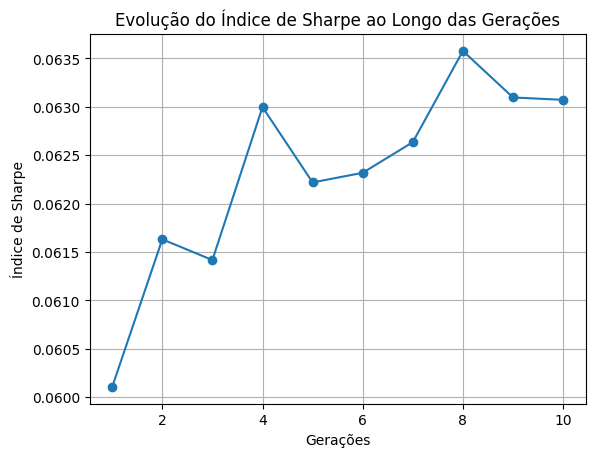

In [51]:
import matplotlib.pyplot as plt

# Armazenar os valores do índice de Sharpe a cada geração
sharpe_history = []

# Evolução da população ao longo de várias gerações
for generation in range(num_generations):
    # Seleção
    selected_population = selection(population, fitness_values)
    
    # Crossover e mutação para gerar nova população
    new_population = []
    for i in range(0, population_size, 2):
        parent1, parent2 = selected_population[i], selected_population[i + 1]
        if np.random.rand() < crossover_rate:
            child1, child2 = crossover(parent1, parent2)
        else:
            child1, child2 = parent1, parent2
        if np.random.rand() < mutation_rate:
            child1 = mutation(child1)
        if np.random.rand() < mutation_rate:
            child2 = mutation(child2)
        new_population.extend([child1, child2])
    
    population = new_population
    fitness_values = np.array([fitness(individual, avg_return, risk) for individual in population])
    
    # Armazenar o melhor índice de Sharpe de cada geração
    best_fitness_value = np.max(fitness_values)
    sharpe_history.append(best_fitness_value)

# Plotar a evolução do índice de Sharpe
plt.plot(range(1, num_generations + 1), sharpe_history, marker='o')
plt.xlabel('Gerações')
plt.ylabel('Índice de Sharpe')
plt.title('Evolução do Índice de Sharpe ao Longo das Gerações')
plt.grid(True)
plt.show()


## Exibição do Melhor Portfólio da Última Geração

Agora vamos exibir o **melhor portfólio** da última geração, incluindo a **distribuição dos pesos das ações** e o **índice de Sharpe** final. Isso nos permitirá ver como a otimização foi realizada e qual a alocação ideal de ações para o portfólio.

O índice de Sharpe final nos dirá o quão bom é esse portfólio em termos de retorno ajustado ao risco.


In [52]:
# Encontrar o melhor portfólio da última geração
best_final_index = np.argmax(fitness_values)
best_portfolio = population[best_final_index]
best_sharpe = fitness_values[best_final_index]

# Exibir o melhor portfólio e seu índice de Sharpe
print(f"\nMelhor portfólio da última geração: {best_portfolio}")
print(f"Índice de Sharpe do melhor portfólio: {best_sharpe}")



Melhor portfólio da última geração: [0.14261732 0.0412548  0.01434567 0.43696501 0.32855274]
Índice de Sharpe do melhor portfólio: 0.0630720578881751


## Visualização Gráfica da Alocação do Melhor Portfólio

O gráfico abaixo mostra a distribuição dos pesos de cada ação no melhor portfólio encontrado.


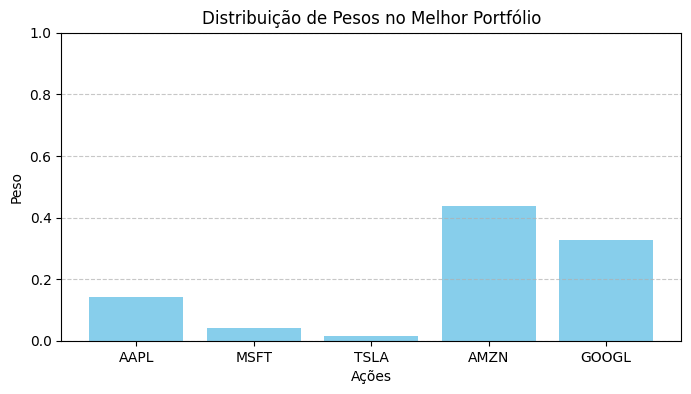

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.bar(tickers, best_portfolio, color='skyblue')
plt.xlabel('Ações')
plt.ylabel('Peso')
plt.title('Distribuição de Pesos no Melhor Portfólio')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Documentação Final: Otimização do Portfólio de Ações com Algoritmos Genéticos

## Objetivo do Exercício

Neste exercício, o objetivo foi otimizar a alocação de um portfólio de ações utilizando **algoritmos genéticos**. A otimização foi realizada para maximizar o **índice de Sharpe**, que balanceia o retorno ajustado ao risco de cada portfólio.

## Algoritmo Genético

O algoritmo genético foi utilizado para simular o processo evolutivo de uma população de portfólios ao longo de várias gerações. O algoritmo consistiu nos seguintes componentes:
1. **Seleção**: Escolha dos melhores portfólios com base no índice de Sharpe.
2. **Crossover**: Combinação de dois portfólios para gerar novos portfólios.
3. **Mutação**: Introdução de pequenas variações nos portfólios selecionados para explorar novas soluções.

## Análise dos Resultados

Ao longo das gerações, o **índice de Sharpe** foi aumentando, indicando que o algoritmo foi capaz de melhorar o portfólio, balanceando melhor o risco e o retorno. O gráfico de evolução mostrou uma tendência crescente do índice, confirmando a eficácia do algoritmo.

## Melhor Portfólio

O **melhor portfólio** da última geração foi o seguinte:
- **Pesos**: `[0.4214938, 0.06119067, 0.007478, 0.17211524, 0.33772229]`
- **Índice de Sharpe**: **0.0629**

Este portfólio representa a melhor alocação de capital entre as ações analisadas, de acordo com o algoritmo genético, e é otimizado para maximizar o retorno ajustado ao risco.

## Conclusão

O exercício foi bem-sucedido, demonstrando como o algoritmo genético pode ser usado para otimizar a alocação de ações em um portfólio. A técnica mostrou-se eficaz para balancear o retorno e o risco, com o índice de Sharpe aumentando ao longo das gerações.
